In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


In [0]:
!pip install https://github.com/fastai/fastai/archive/1.0.49.zip

In [0]:
from fastai.vision import *
from fastai.callbacks import *

In [0]:
from pathlib import Path

In [0]:
bs = 128

## Downloading data

In [0]:
!mkdir data/models
!!wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar -P data/models/

In [0]:
!unzip -q data.zip -d data #Dataset

In [0]:
!ls

data  models


In [0]:
!ls data

models	test_WyRytb0.csv  train  train.csv


In [0]:
path = Path("./data/")
train_path = path/'train.csv'
test_path = path/'test_WyRytb0.csv'
train_path, test_path

(PosixPath('data/train.csv'), PosixPath('data/test_WyRytb0.csv'))

In [0]:
import os
import shutil

In [0]:
os.mkdir(path/'test')

In [0]:
with open(path/'test_WyRytb0.csv') as f:
  fnames = f.read().split()
  for name in fnames:
    try:
      shutil.copy(path/'train'/name, path/'test'/name)
    except Exception as e:
      print(e, "can't copy "+name)

[Errno 2] No such file or directory: 'data/train/image_name' can't copy image_name


In [0]:
!ls data/test

In [0]:
np.random.seed(42)

In [0]:
data = ImageDataBunch.from_csv(path=path, folder='train', csv_labels='train.csv', test='test', ds_tfms=get_transforms(), size=128, bs=bs).normalize(imagenet_stats)

In [0]:
import torchvision
import torch
from collections import OrderedDict

In [0]:
places_res50 = torch.load('data/models/resnet50_places365.pth.tar',  map_location=lambda storage, loc: storage)

In [0]:
default_res50 = models.resnet50()
state_dict = places_res50['state_dict'] 
new_state_dict = OrderedDict()

In [0]:
for key in model_state_dict.keys():
  new_state_dict[key[7:]]= state_dict[key]
  

In [0]:
default_res50.fc = torch.nn.Linear(2048, 365) # Matching with default res50 dense layer
default_res50.load_state_dict(new_state_dict)

In [0]:
def new_resnet(prtn):
  return default_res50

In [0]:
def get_data(sz, bs):
  data = ImageDataBunch.from_csv(path=path, folder='train', csv_labels='train.csv', test='test', ds_tfms=get_transforms(), size=sz, bs=bs).normalize(imagenet_stats)
  return data

In [0]:
learn = cnn_learner(get_data(128, 128), new_resnet, metrics=[error_rate, accuracy])

In [0]:
learn.fit_one_cycle(5)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


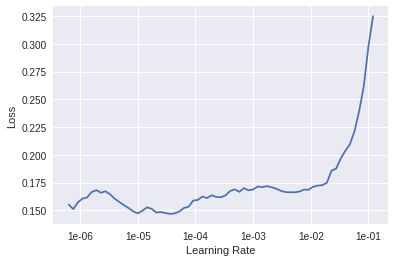

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(6, max_lr=1e-05)

In [0]:
learn.fit_one_cycle(3, max_lr=3e-06)

In [0]:
learn.save('places_res50_128x128')

In [0]:
learn = cnn_learner(get_data(128, 128), new_resnet, metrics=[error_rate, accuracy]).load('places_res50_128x128')

## Create embedding DF

In [0]:
import pandas as pd
import numpy as np

In [0]:
df = pd.read_csv('data/train.csv')

In [0]:
df['index'] = df.image_name.str.split('.').str.slice(0,1).str.join('').astype(int)

In [0]:
df

image_name  label  index
0          0.jpg      0      0
1          1.jpg      4      1
2          2.jpg      5      2
3          4.jpg      0      4
4          7.jpg      4      7
5          8.jpg      1      8
6          9.jpg      5      9
7         10.jpg      2     10
8         12.jpg      5     12
9         13.jpg      2     13
10        15.jpg      2     15
11        16.jpg      3     16
12        17.jpg      3     17
13        18.jpg      2     18
14        19.jpg      5     19
15        20.jpg      4     20
16        21.jpg      4     21
17        23.jpg      1     23
18        24.jpg      2     24
19        26.jpg      5     26
20        27.jpg      4     27
21        29.jpg      5     29
22        31.jpg      5     31
23        32.jpg      3     32
24        33.jpg      5     33
25        34.jpg      3     34
26        35.jpg      5     35
27        36.jpg      5     36
28        37.jpg      5     37
29        39.jpg      5     39
...          ...    ...    ...
17004  24286.jpg      3  24286
17005  24287.jpg      3  24287
17006  24290.jpg      0  24290
17007  24292.jpg      5  24292
17008  24294.jpg      3  24294
17009  24295.jpg      4  24295
17010  24297.jpg      2  24297
17011  24299.jpg      2  24299
17012  24300.jpg      5  24300
17013  24301.jpg      4  24301
17014  24304.jpg      4  24304
17015  24309.jpg      4  24309
17016  24310.jpg      2  24310
17017  24311.jpg      4  24311
17018  24312.jpg      1  24312
17019  24313.jpg      1  24313
17020  24314.jpg      1  24314
17021  24315.jpg      5  24315
17022  24317.jpg      5  24317
17023  24319.jpg      3  24319
17024  24320.jpg      0  24320
17025  24321.jpg      3  24321
17026  24322.jpg      0  24322
17027  24323.jpg      2  24323
17028  24324.jpg      1  24324
17029  24325.jpg      4  24325
17030  24328.jpg      3  24328
17031  24329.jpg      3  24329
17032  24332.jpg      5  24332
17033  24334.jpg      2  24334

[17034 rows x 3 columns]

In [0]:
df['embedding'] = list(train_preds.numpy())

In [0]:
df.to_csv('train_embeddings.csv', index=False)

In [0]:
test_df = pd.DataFrame({'image_name': os.listdir('data/test'), 'embeddings': list(test_preds.numpy())})
test_df.to_csv('test_embeddings.csv', index=False)

In [0]:
train_df = df.copy()

## Annoy

In [0]:
!pip install annoy --upgrade

    100% |████████████████████████████████| 645kB 21.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/77/cb/7a/6f3ed44099e394e0cb0b6b41213b61fe6595b726530744f2ce
Successfully built annoy


In [0]:
from annoy import AnnoyIndex
import random

# for i in xrange(1000):
#     v = [random.gauss(0, 1) for z in xrange(f)]
#     t.add_item(i, v)

# t.build(10) # 10 trees
# t.save('test.ann')

# # ...

# u = AnnoyIndex(f)
# u.load('test.ann') # super fast, will just mmap the file
# print(u.get_nns_by_item(0, 1000)) # will find the 1000 nearest neighbors

In [0]:
f = 512
a_index = AnnoyIndex(f, metric="angular")  # Length of item vector that will be indexed

In [0]:
for row in train_df.iterrows():
  a_index.add_item(row[1]['index'], row[1].embedding)
#   print(row[1]['index'], row[1].embedding.shape)

In [0]:
a_index.build(50) # num trees
a_index.save('test.ann')

True

In [0]:
a_index = AnnoyIndex(f)
a_index.load('test.ann') 

True

In [0]:
a_index.get_nns_by_vector(test_df.embeddings.values[0], 5)

[776, 23201, 9334, 7164, 20068]

In [0]:
result_index = a_index.get_nns_by_item(50, 5)

In [0]:
result_index

[50, 21125, 18360, 11090, 23511]

In [0]:
a_index.get_distance(50,21125)

0.3449389636516571

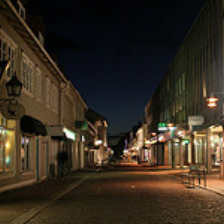

In [0]:
img = open_image(path/'train'/(str(result_index[0])+'.jpg'))
img.resize(224)

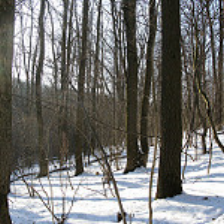

In [0]:
img = open_image(path/'train'/(str(result_index[1])+'.jpg'))
img.resize(224)

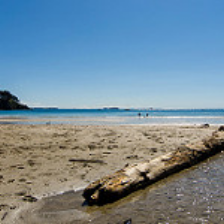

In [0]:
img = open_image(path/'train'/(str(result_index[2])+'.jpg'))
img.resize(224)

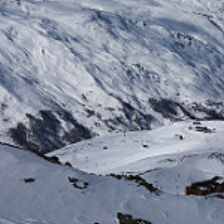

In [0]:
img = open_image(path/'train'/(str(result_index[3])+'.jpg'))
img.resize(224)

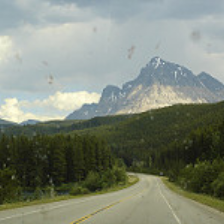

In [0]:
img = open_image(path/'train'/(str(result_index[4])+'.jpg'))
img.resize(224)

In [0]:
img = open_image(path/'train'/(str(result_index[5])+'.jpg'))
img.resize(224)

IndexError: ignored

## Using get_actns function

In [0]:
from fastai.widgets import DatasetFormatter
from fastai.callbacks.hooks import hook_output

In [0]:
def get_data_test(sz, bs):
  data = ImageDataBunch.from_csv(path=path, folder='train', csv_labels='train.csv', test='train', size=128, bs=157, valid_pct=0).normalize(imagenet_stats)
  return data

In [0]:
data = ImageDataBunch.from_csv(path=path, folder='train', csv_labels='train.csv', test='train', size=128, bs=157, valid_pct=0).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(get_data_test(128, 157), get_resnet, metrics=[error_rate, accuracy]).load('places_res50_128x128')

In [0]:
# learn.model

In [0]:
layer_ls=[1, 4]

In [0]:
hook = hook_output(learn.model[layer_ls[0]][layer_ls[1]])

In [0]:
test_activations = DatasetFormatter.get_actns(learn, hook=hook, dl = data.test_dl, pool_dim=0, pool=False)

Getting activations...


In [0]:
test_activations.shape

torch.Size([24335, 512])

In [0]:
import pandas as pd
import numpy as np

In [0]:
# Train and Test is combined in train folder

In [0]:
test_df = pd.DataFrame({'image_name': os.listdir('data/train'), 'embeddings': list(test_activations.numpy())})
test_df.to_csv('test_embeddings.csv', index=False)

In [0]:
test_df.head()

embeddings image_name
0  [0.0, 0.7495579, 0.0, 0.0, 0.0, 0.0, 0.0, 1.68...   9344.jpg
1  [1.4144694, 2.481277, 0.0, 0.3527194, 0.0, 0.0...  12007.jpg
2  [0.0, 1.1596466, 0.0, 0.0, 0.0, 0.0, 0.0, 5.14...  23730.jpg
3  [5.3547087, 0.0, 2.1044884, 1.1254079, 0.0, 2....  11884.jpg
4  [2.1766658, 0.0, 0.09812791, 0.0, 2.8100889, 0...   7015.jpg

In [0]:
actual_test_df = pd.read_csv(path/'test_WyRytb0.csv')

In [0]:
actual_train_df = test_df[~test_df['image_name'].isin(actual_test_df['image_name'])]

In [0]:
actual_train_df.shape

(17034, 2)

In [0]:
actual_test_df = test_df[test_df['image_name'].isin(actual_test_df['image_name'])]
actual_test_df.shape

(7301, 2)

In [0]:
actual_test_df['index'] = actual_test_df.image_name.str.split('.').str.slice(0,1).str.join('').astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
actual_train_df['index'] = actual_train_df.image_name.str.split('.').str.slice(0,1).str.join('').astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
actual_train_df.head(10)

embeddings image_name  index
0   [0.0, 0.7495579, 0.0, 0.0, 0.0, 0.0, 0.0, 1.68...   9344.jpg   9344
1   [1.4144694, 2.481277, 0.0, 0.3527194, 0.0, 0.0...  12007.jpg  12007
4   [2.1766658, 0.0, 0.09812791, 0.0, 2.8100889, 0...   7015.jpg   7015
5   [4.5784616, 0.0, 0.0, 2.2294056, 5.377418, 7.3...  10792.jpg  10792
6   [5.249807, 0.0, 8.038217, 0.0, 3.513136, 5.805...  14720.jpg  14720
8   [2.4078648, 2.6259904, 0.0, 0.0, 5.333513, 0.0...  17421.jpg  17421
9   [0.0, 0.0, 0.0, 1.9963884, 0.0, 0.0, 1.9407356...  15189.jpg  15189
10  [0.0075616017, 0.0, 1.9302577, 5.8733296, 0.0,...  12571.jpg  12571
12  [0.26398587, 0.0, 0.0, 0.0, 6.976759, 1.911598...   8292.jpg   8292
13  [2.4886966, 0.0, 1.2837439, 0.0, 5.231753, 0.0...  11938.jpg  11938

In [0]:
from annoy import AnnoyIndex
import random

In [0]:
f = 512
a_index = AnnoyIndex(f, metric="angular")  # Length of item vector that will be indexed

In [0]:
for row in actual_train_df.iterrows():
  a_index.add_item(row[1]['index'], row[1].embeddings)

In [0]:
a_index.build(100) # num trees
a_index.save('test.ann')

True

### Tests

In [0]:
result_index = a_index.get_nns_by_item(5, 5)

In [0]:
result_index

[32, 58, 118, 232, 297]

In [0]:
a_index.get_distance(1,5)

1.4142135381698608

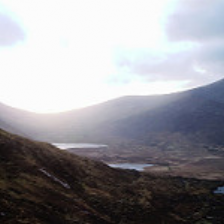

In [0]:
img = open_image(path/'train'/(str(result_index[0])+'.jpg'))
img.resize(224)

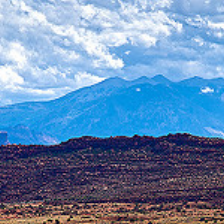

In [0]:
img = open_image(path/'train'/(str(result_index[1])+'.jpg'))
img.resize(224)

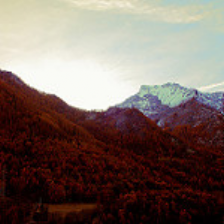

In [0]:
img = open_image(path/'train'/(str(result_index[2])+'.jpg'))
img.resize(224)

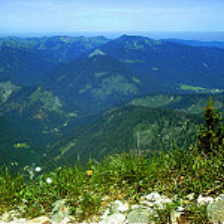

In [0]:
img = open_image(path/'train'/(str(result_index[3])+'.jpg'))
img.resize(224)

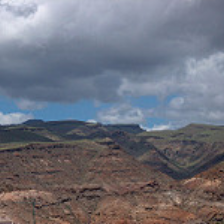

In [0]:
img = open_image(path/'train'/(str(result_index[4])+'.jpg'))
img.resize(224)

In [0]:
result_index = a_index.get_nns_by_vector(actual_test_df['embeddings'].values[0], 5, include_distances=True)
result_index

([16504, 11128, 14512, 6825, 250],
 [0.3124006986618042,
  0.31924211978912354,
  0.3246363401412964,
  0.33046990633010864,
  0.33555901050567627])

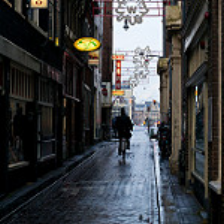

In [0]:
img = open_image(path/'test'/(actual_test_df['image_name'].values[0]))
img.resize(224)

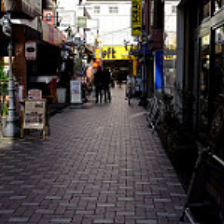

In [0]:
img = open_image(path/'train'/(str(result_index[0][0])+'.jpg'))
img.resize(224)

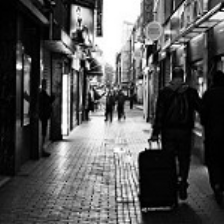

In [0]:
img = open_image(path/'train'/(str(result_index[0][1])+'.jpg'))
img.resize(224)

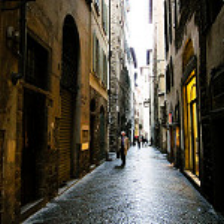

In [0]:
img = open_image(path/'train'/(str(result_index[0][2])+'.jpg'))
img.resize(224)

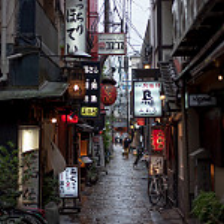

In [0]:
img = open_image(path/'train'/(str(result_index[0][3])+'.jpg'))
img.resize(224)

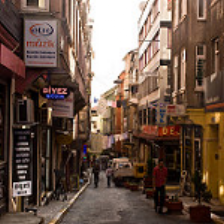

In [0]:
img = open_image(path/'train'/(str(result_index[0][4])+'.jpg'))
img.resize(224)

## Getting Top Neighbours

In [0]:
top_100 = list()
top_100_weigths = list()

In [0]:
for row in actual_test_df.iterrows():
  result_index = a_index.get_nns_by_vector(row[1]['embeddings'], 500, include_distances=True)
  top_100.append(result_index[0])
  top_100_weigths.append(result_index[1])

In [0]:
top_100_weigths

In [0]:
actual_test_df['top_100'] = top_100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
actual_test_df['top_100_weigths'] = top_100_weigths

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
actual_test_df.head(10)

embeddings image_name  index  \
0   [0.0, 1.4469041, 7.867027, 1.8012073, 0.438483...   5839.jpg   5839   
2   [6.343175, 1.778364, 0.0, 0.0, 3.2334762, 0.74...   4121.jpg   4121   
5   [0.0, 1.1582344, 0.4118398, 0.17285855, 0.3197...  18540.jpg  18540   
6   [1.8779175, 3.0445683, 0.0, 0.2409918, 1.57513...   7082.jpg   7082   
12  [1.1007874, 0.0, 0.0, 3.315866, 0.0, 0.0, 0.0,...   3916.jpg   3916   
13  [3.0279255, 0.0, 0.0, 3.621935, 0.0, 0.0, 0.0,...  14921.jpg  14921   
15  [0.0, 0.17951648, 0.46520498, 0.0, 1.6123694, ...   2682.jpg   2682   
17  [2.4568582, 0.92823327, 1.0775198, 0.42609996,...  10147.jpg  10147   
18  [0.0, 0.0, 3.7601895, 0.8503336, 0.36399323, 0...  21252.jpg  21252   
19  [0.09093785, 0.060308203, 0.0, 3.4643402, 0.0,...  11546.jpg  11546   

                                              top_100  \
0   [16504, 11128, 14512, 6825, 250, 19163, 15373,...   
2   [14856, 8518, 10520, 15701, 22045, 16795, 2367...   
5   [22711, 15011, 18244, 14237, 5551, 13736, 2179...   
6   [6597, 13736, 4027, 17803, 18999, 16932, 10122...   
12  [11677, 5698, 4541, 22202, 15477, 8937, 11457,...   
13  [14400, 22209, 21276, 3990, 20444, 100, 12368,...   
15  [9025, 8255, 1025, 14931, 8495, 14702, 9319, 2...   
17  [3053, 17760, 19461, 14337, 2671, 19585, 299, ...   
18  [21371, 12388, 15343, 9667, 16155, 18558, 1413...   
19  [9633, 21173, 1794, 9050, 20189, 5576, 5018, 1...   

                                      top_100_weigths  \
0   [0.3124006986618042, 0.31924211978912354, 0.32...   
2   [0.34510645270347595, 0.3763233721256256, 0.39...   
5   [0.5153306722640991, 0.515880286693573, 0.5410...   
6   [0.5308048725128174, 0.5317164659500122, 0.536...   
12  [0.47319114208221436, 0.49297428131103516, 0.5...   
13  [0.4100639522075653, 0.4113156497478485, 0.411...   
15  [0.310720294713974, 0.33358633518218994, 0.338...   
17  [0.6045175194740295, 0.6270992755889893, 0.629...   
18  [0.3093416392803192, 0.328799307346344, 0.3413...   
19  [0.377341091632843, 0.3926125764846802, 0.3954...   

                                         train_labels  \
0   [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
2   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
5   [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...   
6   [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...   
12  [3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...   
13  [3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...   
15  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
17  [4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 0, 4, 4, 5, 4, ...   
18  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
19  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, ...   

                                         final_scores  
0   {0.4340396821498871: 0, nan: 1, nan: 2, nan: 3...  
2   {0.38147847056388856: 0, nan: 1, nan: 2, nan: ...  
5   {nan: 0, nan: 1, nan: 2, nan: 3, 0.53314778804...  
6   {nan: 0, nan: 1, nan: 2, nan: 3, 0.53820229768...  
12  {nan: 0, nan: 1, 0.5720480799674987: 2, 0.5089...  
13  {nan: 0, nan: 1, 0.5114304482936859: 2, 0.4268...  
15  {nan: 0, 0.33345301151275636: 1, nan: 2, nan: ...  
17  {0.7056068658828736: 0, nan: 1, nan: 2, nan: 3...  
18  {nan: 0, 0.334816175699234: 1, nan: 2, nan: 3,...  
19  {nan: 0, nan: 1, 0.48159700632095337: 2, 0.398...

In [0]:
actual_train_label=dict()

In [0]:
train_csv = pd.read_csv(path/'train.csv')

In [0]:
19163 in train_csv['image_name'].values

True

In [0]:
train_csv['image_name'] = train_csv.image_name.str.split('.').str.slice(0,1).str.join('').astype(int)

In [0]:
actual_train_label = train_csv.set_index('image_name').to_dict()['label']

In [0]:
actual_train_label

In [0]:
train_labels = list()
for row in top_100:
  img_labels = list()
  for img in row:
    img_labels.append(actual_train_label[img])
  train_labels.append(img_labels)

In [0]:
actual_train_label[19163]

5

In [0]:
train_labels

[[5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  0,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]

In [0]:
actual_test_df['train_labels'] = train_labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
actual_test_df.head()

embeddings image_name  index  \
0   [0.0, 1.4469041, 7.867027, 1.8012073, 0.438483...   5839.jpg   5839   
2   [6.343175, 1.778364, 0.0, 0.0, 3.2334762, 0.74...   4121.jpg   4121   
5   [0.0, 1.1582344, 0.4118398, 0.17285855, 0.3197...  18540.jpg  18540   
6   [1.8779175, 3.0445683, 0.0, 0.2409918, 1.57513...   7082.jpg   7082   
12  [1.1007874, 0.0, 0.0, 3.315866, 0.0, 0.0, 0.0,...   3916.jpg   3916   

                                              top_100  \
0   [16504, 11128, 14512, 6825, 250, 19163, 15373,...   
2   [14856, 8518, 10520, 15701, 22045, 16795, 2367...   
5   [22711, 15011, 18244, 14237, 5551, 13736, 2179...   
6   [6597, 13736, 4027, 17803, 18999, 16932, 10122...   
12  [11677, 5698, 4541, 22202, 15477, 8937, 11457,...   

                                      top_100_weigths  \
0   [0.3124006986618042, 0.31924211978912354, 0.32...   
2   [0.34510645270347595, 0.3763233721256256, 0.39...   
5   [0.5153306722640991, 0.515880286693573, 0.5410...   
6   [0.5308048725128174, 0.5317164659500122, 0.536...   
12  [0.47319114208221436, 0.49297428131103516, 0.5...   

                                         train_labels  
0   [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...  
2   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
5   [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...  
6   [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...  
12  [3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...

In [0]:
sample_submission = pd.DataFrame()
sample_submission['image_name'] = actual_test_df['image_name']

In [0]:
label_list = list()
for label in train_labels:
  value = max(label,key=label.count)
  label_list.append(value)

In [0]:
label_list

In [0]:
sample_submission['label'] = label_list

In [0]:
sample_submission.head(10)

image_name  label
0    5839.jpg      5
2    4121.jpg      0
5   18540.jpg      4
6    7082.jpg      4
12   3916.jpg      3
13  14921.jpg      3
15   2682.jpg      1
17  10147.jpg      4
18  21252.jpg      1
19  11546.jpg      3

In [0]:
sample_submission.to_csv('sample_submission.csv', index=False)

In [0]:
def make_submission(learn, filename):
  log_preds, test_labels = learn.get_preds(ds_type=DatasetType.Test)
  preds = np.argmax(log_preds, 1)
  a = np.array(preds)
  submission = pd.DataFrame({'image_name': os.listdir('data/test'), 'label': a})
  submission.to_csv(path/filename, index=False)

In [0]:
make_submission(learn, 'places_res50_128x128_standalone_submission_for_annoy.csv')

In [0]:
values = np.array(train_labels[0])

In [0]:
ii = np.where(values == 5)[0][:5]

In [0]:
ii

array([0, 1, 2, 3, 4])

In [0]:
ii.shape[0]

5

In [0]:
weights = np.array(top_100_weigths[0])

In [0]:
weights

array([0.312401, 0.319242, 0.324636, 0.33047 , ..., 0.437691, 0.437816, 0.438137, 0.438215])

In [0]:
weights[ii]

array([0.312401, 0.319242, 0.324636, 0.33047 , 0.335559])

In [0]:
final_scores = list()

In [0]:
for index, labels in enumerate(train_labels):
  weigths_dict = dict()
  values = np.array(labels)
  weights = np.array(top_100_weigths[index])
  for label_id in range(6):
    ii = np.where(values == label_id)[0][:5]
    weigths_dict[np.sum(weights[ii])/min(ii.shape[0], 5)] =  label_id
  final_scores.append(weigths_dict)
      


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [0]:
final_scores

[{0.4340396821498871: 0,
  nan: 1,
  nan: 2,
  nan: 3,
  nan: 4,
  0.3244616150856018: 5},
 {0.38147847056388856: 0, nan: 1, nan: 2, nan: 3, nan: 4, nan: 5},
 {nan: 0, nan: 1, nan: 2, nan: 3, 0.5331477880477905: 4, nan: 5},
 {nan: 0, nan: 1, nan: 2, nan: 3, 0.5382022976875305: 4, nan: 5},
 {nan: 0,
  nan: 1,
  0.5089929461479187: 3,
  0.5720480799674987: 2,
  nan: 4,
  nan: 5},
 {nan: 0,
  nan: 1,
  0.42685129046440123: 3,
  0.5114304482936859: 2,
  nan: 4,
  nan: 5},
 {nan: 0, 0.33345301151275636: 1, nan: 2, nan: 3, nan: 4, nan: 5},
 {0.7056068658828736: 0,
  nan: 1,
  nan: 2,
  nan: 3,
  0.6301105260848999: 4,
  0.6994249820709229: 5},
 {nan: 0, 0.334816175699234: 1, nan: 2, nan: 3, nan: 4, nan: 5},
 {nan: 0,
  nan: 1,
  0.3981274366378784: 3,
  0.48159700632095337: 2,
  nan: 4,
  nan: 5},
 {nan: 0, nan: 1, nan: 2, nan: 3, 0.35942694544792175: 4, nan: 5},
 {nan: 0, nan: 1, 0.3341408371925354: 2, nan: 3, nan: 4, nan: 5},
 {nan: 0,
  nan: 1,
  0.397929185628891: 3,
  0.4630748510360717

In [0]:
actual_test_df["final_scores"] = final_scores

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
actual_test_df.head()

embeddings image_name  index  \
0   [0.0, 1.4469041, 7.867027, 1.8012073, 0.438483...   5839.jpg   5839   
2   [6.343175, 1.778364, 0.0, 0.0, 3.2334762, 0.74...   4121.jpg   4121   
5   [0.0, 1.1582344, 0.4118398, 0.17285855, 0.3197...  18540.jpg  18540   
6   [1.8779175, 3.0445683, 0.0, 0.2409918, 1.57513...   7082.jpg   7082   
12  [1.1007874, 0.0, 0.0, 3.315866, 0.0, 0.0, 0.0,...   3916.jpg   3916   

                                              top_100  \
0   [16504, 11128, 14512, 6825, 250, 19163, 15373,...   
2   [14856, 8518, 10520, 15701, 22045, 16795, 2367...   
5   [22711, 15011, 18244, 14237, 5551, 13736, 2179...   
6   [6597, 13736, 4027, 17803, 18999, 16932, 10122...   
12  [11677, 5698, 4541, 22202, 15477, 8937, 11457,...   

                                      top_100_weigths  \
0   [0.3124006986618042, 0.31924211978912354, 0.32...   
2   [0.34510645270347595, 0.3763233721256256, 0.39...   
5   [0.5153306722640991, 0.515880286693573, 0.5410...   
6   [0.5308048725128174, 0.5317164659500122, 0.536...   
12  [0.47319114208221436, 0.49297428131103516, 0.5...   

                                         train_labels  \
0   [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
2   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
5   [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...   
6   [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...   
12  [3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...   

                                         final_scores  
0   {0.4340396821498871: 0, nan: 1, nan: 2, nan: 3...  
2   {0.38147847056388856: 0, nan: 1, nan: 2, nan: ...  
5   {nan: 0, nan: 1, nan: 2, nan: 3, 0.53314778804...  
6   {nan: 0, nan: 1, nan: 2, nan: 3, 0.53820229768...  
12  {nan: 0, nan: 1, 0.5720480799674987: 2, 0.5089...

In [0]:
final_submission = pd.DataFrame()

In [0]:
final_submission['image_name'] = actual_test_df['image_name']

In [0]:
label_values = list()

In [0]:
for final_dict in final_scores:
  k = np.nanmin(list(final_dict.keys()))
  print(k)
  label_values.append(final_dict[k])

0.3244616150856018
0.38147847056388856
0.5331477880477905
0.5382022976875305
0.5089929461479187
0.42685129046440123
0.33345301151275636
0.6301105260848999
0.334816175699234
0.3981274366378784
0.35942694544792175
0.3341408371925354
0.397929185628891
0.4527843534946442
0.5062921583652497
0.39045738577842715
0.3181517541408539
0.5299903750419617
0.3357320249080658
0.44606130123138427
0.22738696336746217
0.5176836371421814
0.5639983296394349
0.4635631084442139
0.308720201253891
0.4403890252113342
0.33686097860336306
0.5453998565673828
0.7580690860748291
0.48500511050224304
0.23362326622009277
0.5117160320281983
0.4720510900020599
0.4293846607208252
0.5980772495269775
0.34860066175460813
0.5742295503616333
0.4544093251228333
0.433534300327301
0.4726867079734802
0.6445393800735474
0.8299500823020936
0.4390392184257507
0.4213023602962494
0.4117256045341492
0.3331156253814697
0.31647292971611024
0.38893110156059263
0.34571685194969176
0.38294572234153745
0.39477107524871824
0.42389826774597167

In [0]:
label_values

[5,
 0,
 4,
 4,
 3,
 3,
 1,
 4,
 1,
 3,
 4,
 2,
 3,
 0,
 1,
 3,
 5,
 4,
 4,
 4,
 2,
 0,
 3,
 4,
 4,
 0,
 5,
 2,
 3,
 3,
 1,
 0,
 1,
 3,
 2,
 2,
 2,
 4,
 0,
 1,
 2,
 0,
 3,
 0,
 0,
 5,
 5,
 4,
 0,
 3,
 1,
 0,
 3,
 0,
 1,
 4,
 0,
 1,
 3,
 0,
 3,
 3,
 5,
 1,
 4,
 4,
 5,
 0,
 5,
 2,
 5,
 0,
 1,
 1,
 5,
 1,
 2,
 2,
 2,
 2,
 3,
 0,
 1,
 1,
 3,
 1,
 1,
 2,
 0,
 4,
 2,
 2,
 5,
 1,
 2,
 1,
 2,
 1,
 3,
 0,
 3,
 0,
 0,
 2,
 2,
 5,
 4,
 3,
 3,
 5,
 1,
 3,
 2,
 2,
 4,
 4,
 2,
 5,
 3,
 0,
 4,
 0,
 4,
 3,
 4,
 5,
 0,
 1,
 2,
 3,
 4,
 2,
 1,
 5,
 5,
 2,
 4,
 3,
 5,
 0,
 0,
 1,
 4,
 2,
 3,
 3,
 5,
 5,
 0,
 0,
 2,
 1,
 1,
 3,
 5,
 4,
 2,
 0,
 2,
 4,
 1,
 4,
 3,
 1,
 5,
 1,
 5,
 3,
 3,
 4,
 5,
 2,
 2,
 2,
 5,
 3,
 1,
 0,
 0,
 4,
 3,
 2,
 4,
 0,
 5,
 5,
 5,
 2,
 4,
 0,
 5,
 1,
 1,
 1,
 2,
 3,
 4,
 3,
 2,
 2,
 5,
 4,
 4,
 0,
 2,
 0,
 3,
 0,
 5,
 2,
 1,
 5,
 0,
 3,
 5,
 5,
 3,
 1,
 1,
 1,
 1,
 0,
 3,
 5,
 3,
 1,
 2,
 0,
 4,
 2,
 4,
 5,
 3,
 3,
 5,
 3,
 2,
 5,
 2,
 1,
 0,
 1,
 3,
 3,
 1,
 5,
 2,
 2,
 2,
 0,


In [0]:
final_submission['label'] = label_values

In [0]:
final_submission.head()

image_name  label
0    5839.jpg      5
2    4121.jpg      0
5   18540.jpg      4
6    7082.jpg      4
12   3916.jpg      3

In [0]:
final_submission.to_csv('final.csv', index=False)

## Top 10

In [0]:
top_10 = list()
top_10_weigths = list()

In [0]:
for row in actual_test_df.iterrows():
  result_index = a_index.get_nns_by_vector(row[1]['embeddings'], 10, include_distances=True)
  top_10.append(result_index[0])
  top_10_weigths.append(result_index[1])

In [0]:
top_10_weigths

[[0.5031185150146484,
  0.5136579871177673,
  0.5438567996025085,
  0.5440167784690857,
  0.5480439066886902,
  0.5573028326034546,
  0.5593563318252563,
  0.5608460307121277,
  0.5612363815307617,
  0.5673258900642395],
 [0.35468214750289917,
  0.3618977665901184,
  0.3625822067260742,
  0.3649043142795563,
  0.37926164269447327,
  0.3816037178039551,
  0.3828497529029846,
  0.38614264130592346,
  0.3946759104728699,
  0.3993474543094635],
 [0.5332534909248352,
  0.545080840587616,
  0.5642467737197876,
  0.5686363577842712,
  0.5767256021499634,
  0.5961205363273621,
  0.6054051518440247,
  0.6085357666015625,
  0.6099458336830139,
  0.6140643954277039],
 [0.3717077970504761,
  0.3731597065925598,
  0.3796536326408386,
  0.3921133577823639,
  0.39498838782310486,
  0.39920711517333984,
  0.402486115694046,
  0.40666595101356506,
  0.4215005040168762,
  0.42208120226860046],
 [0.3729083240032196,
  0.3755594491958618,
  0.4000512659549713,
  0.40232497453689575,
  0.40350326895713806,

In [0]:
actual_test_df['top_10'] = top_10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
actual_test_df['top_10_weigths'] = top_10_weigths

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
actual_test_df.head(10)

embeddings image_name  index  \
2   [0.0, 1.1596466, 0.0, 0.0, 0.0, 0.0, 0.0, 5.14...  23730.jpg  23730   
3   [5.3547087, 0.0, 2.1044884, 1.1254079, 0.0, 2....  11884.jpg  11884   
7   [2.8502207, 0.0, 0.0, 0.0, 0.0, 1.0184838, 0.0...  19149.jpg  19149   
11  [2.509481, 0.0, 1.5080135, 5.495167, 0.0, 0.0,...  19012.jpg  19012   
19  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.7738965,...  21111.jpg  21111   
20  [2.983708, 0.0, 8.313313, 0.0, 0.0, 1.8818668,...  11805.jpg  11805   
24  [0.0, 7.2927403, 0.0, 0.0, 0.0, 0.0, 8.081377,...   6764.jpg   6764   
26  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.2624097,...  13074.jpg  13074   
32  [0.0, 0.0, 0.0, 7.2398634, 0.0, 1.0878147, 0.0...  21184.jpg  21184   
40  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.4177103,...   9975.jpg   9975   

                                               top_10  \
2   [16101, 21463, 12418, 16876, 13602, 23150, 740...   
3   [13160, 21730, 18643, 9745, 4861, 6634, 19225,...   
7   [13855, 20584, 19186, 8377, 10361, 12472, 7421...   
11  [9898, 15250, 23408, 6960, 22083, 1124, 7396, ...   
19  [11266, 13691, 14009, 10874, 19037, 16260, 101...   
20  [10431, 2405, 15943, 2527, 20222, 5705, 21560,...   
24  [17387, 24184, 3460, 914, 13013, 7346, 11284, ...   
26  [12924, 8048, 16448, 13403, 594, 3868, 12872, ...   
32  [3031, 16049, 386, 15393, 8920, 3426, 4041, 21...   
40  [6048, 16308, 21512, 15076, 16260, 17758, 2353...   

                                       top_10_weigths  
2   [0.5031185150146484, 0.5136579871177673, 0.543...  
3   [0.35468214750289917, 0.3618977665901184, 0.36...  
7   [0.5332534909248352, 0.545080840587616, 0.5642...  
11  [0.3717077970504761, 0.3731597065925598, 0.379...  
19  [0.3729083240032196, 0.3755594491958618, 0.400...  
20  [0.24310685694217682, 0.2566463053226471, 0.25...  
24  [0.3923146426677704, 0.39584770798683167, 0.41...  
26  [0.23963981866836548, 0.2725715935230255, 0.27...  
32  [0.36974960565567017, 0.3772844076156616, 0.40...  
40  [0.4236212968826294, 0.4539085924625397, 0.457...

In [0]:
actual_train_label=dict()

In [0]:
train_csv = pd.read_csv(path/'train.csv')

In [0]:
train_csv['image_name'] = train_csv.image_name.str.split('.').str.slice(0,1).str.join('').astype(int)

In [0]:
actual_train_label = train_csv.set_index('image_name').to_dict()['label']

In [0]:
actual_train_label

{0: 0,
 1: 4,
 2: 5,
 4: 0,
 7: 4,
 8: 1,
 9: 5,
 10: 2,
 12: 5,
 13: 2,
 15: 2,
 16: 3,
 17: 3,
 18: 2,
 19: 5,
 20: 4,
 21: 4,
 23: 1,
 24: 2,
 26: 5,
 27: 4,
 29: 5,
 31: 5,
 32: 3,
 33: 5,
 34: 3,
 35: 5,
 36: 5,
 37: 5,
 39: 5,
 40: 2,
 41: 1,
 42: 3,
 43: 2,
 44: 3,
 45: 5,
 46: 1,
 47: 0,
 48: 1,
 49: 1,
 50: 5,
 53: 0,
 54: 2,
 55: 0,
 56: 5,
 57: 2,
 58: 3,
 59: 4,
 60: 2,
 62: 4,
 65: 4,
 66: 0,
 67: 2,
 68: 2,
 71: 3,
 74: 5,
 75: 2,
 78: 4,
 80: 5,
 82: 2,
 83: 5,
 85: 3,
 86: 5,
 87: 4,
 89: 4,
 90: 4,
 91: 5,
 92: 0,
 94: 5,
 95: 3,
 96: 0,
 97: 4,
 98: 1,
 100: 2,
 102: 4,
 104: 5,
 105: 2,
 106: 5,
 107: 4,
 108: 5,
 109: 2,
 111: 1,
 112: 0,
 113: 5,
 114: 1,
 115: 1,
 116: 4,
 118: 3,
 120: 3,
 122: 3,
 123: 1,
 124: 4,
 125: 0,
 128: 2,
 131: 1,
 134: 1,
 136: 4,
 137: 0,
 138: 5,
 139: 0,
 142: 0,
 146: 0,
 147: 5,
 148: 3,
 150: 5,
 151: 5,
 153: 3,
 154: 0,
 155: 3,
 157: 0,
 158: 0,
 159: 5,
 160: 5,
 162: 5,
 163: 2,
 164: 5,
 165: 4,
 166: 5,
 167: 1,
 168: 5,


In [0]:
train_labels = list()
for row in top_10:
  img_labels = list()
  for img in row:
    img_labels.append(actual_train_label[img])
  train_labels.append(img_labels)

In [0]:
train_labels

[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [2, 2, 2, 2, 3, 2, 2, 2, 2, 2],
 [3, 3, 3, 2, 3, 3, 2, 3, 3, 3],
 [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 [2, 2, 2, 2, 2, 2, 2, 3, 3, 3],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [5, 5, 5, 5, 0, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
 [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [5, 5, 5,

In [0]:
actual_test_df['train_labels'] = train_labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
actual_test_df.head()

embeddings image_name  index  \
2   [0.0, 1.1596466, 0.0, 0.0, 0.0, 0.0, 0.0, 5.14...  23730.jpg  23730   
3   [5.3547087, 0.0, 2.1044884, 1.1254079, 0.0, 2....  11884.jpg  11884   
7   [2.8502207, 0.0, 0.0, 0.0, 0.0, 1.0184838, 0.0...  19149.jpg  19149   
11  [2.509481, 0.0, 1.5080135, 5.495167, 0.0, 0.0,...  19012.jpg  19012   
19  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.7738965,...  21111.jpg  21111   

                                               top_10  \
2   [16101, 21463, 12418, 16876, 13602, 23150, 740...   
3   [13160, 21730, 18643, 9745, 4861, 6634, 19225,...   
7   [13855, 20584, 19186, 8377, 10361, 12472, 7421...   
11  [9898, 15250, 23408, 6960, 22083, 1124, 7396, ...   
19  [11266, 13691, 14009, 10874, 19037, 16260, 101...   

                                       top_10_weigths  \
2   [0.5031185150146484, 0.5136579871177673, 0.543...   
3   [0.35468214750289917, 0.3618977665901184, 0.36...   
7   [0.5332534909248352, 0.545080840587616, 0.5642...   
11  [0.3717077970504761, 0.3731597065925598, 0.379...   
19  [0.3729083240032196, 0.3755594491958618, 0.400...   

                      train_labels  
2   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]  
3   [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]  
7   [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]  
11  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]  
19  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [0]:
weights = np.array(top_10_weigths[0])

In [0]:
weights

array([0.503119, 0.513658, 0.543857, 0.544017, 0.548044, 0.557303, 0.559356, 0.560846, 0.561236, 0.567326])

In [0]:
final_scores = list()

In [0]:
for index, labels in enumerate(train_labels):
  weigths_dict = dict()
  values = np.array(labels)
  weights = np.array(top_10_weigths[index])
  for label_id in range(6):
    ii = np.where(values == label_id)[0][:5]
    weigths_dict[np.sum(weights[ii])/min(ii.shape[0], 5)] =  label_id
  final_scores.append(weigths_dict)
      


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [0]:
final_scores

[{nan: 0, nan: 1, 0.53053879737854: 2, nan: 3, nan: 4, nan: 5},
 {nan: 0, nan: 1, nan: 2, nan: 3, 0.36466561555862426: 4, nan: 5},
 {nan: 0, nan: 1, nan: 2, 0.5575886130332947: 3, nan: 4, nan: 5},
 {nan: 0, nan: 1, nan: 2, nan: 3, 0.38232457637786865: 4, nan: 5},
 {nan: 0, nan: 1, 0.3908694565296173: 2, nan: 3, nan: 4, nan: 5},
 {nan: 0, nan: 1, nan: 2, nan: 3, nan: 4, 0.25621000230312346: 5},
 {nan: 0, nan: 1, nan: 2, 0.4088911533355713: 3, nan: 4, nan: 5},
 {nan: 0, nan: 1, 0.26991060972213743: 2, nan: 3, nan: 4, nan: 5},
 {nan: 0, nan: 1, nan: 2, nan: 3, 0.3986684322357178: 4, nan: 5},
 {nan: 0, nan: 1, 0.4516142249107361: 2, nan: 3, nan: 4, nan: 5},
 {nan: 0, nan: 1, nan: 2, nan: 3, 0.5463711857795716: 4, nan: 5},
 {0.4406977415084839: 0, nan: 1, nan: 2, nan: 3, nan: 4, nan: 5},
 {nan: 0, nan: 1, nan: 2, 0.35755226016044617: 3, nan: 4, nan: 5},
 {nan: 0, nan: 1, 0.4802135705947876: 2, 0.517365574836731: 3, nan: 4, nan: 5},
 {nan: 0,
  nan: 1,
  0.4774013876914978: 3,
  0.4869951903

In [0]:
actual_test_df["final_scores"] = final_scores

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
actual_test_df.head()

embeddings image_name  index  \
2   [0.0, 1.1596466, 0.0, 0.0, 0.0, 0.0, 0.0, 5.14...  23730.jpg  23730   
3   [5.3547087, 0.0, 2.1044884, 1.1254079, 0.0, 2....  11884.jpg  11884   
7   [2.8502207, 0.0, 0.0, 0.0, 0.0, 1.0184838, 0.0...  19149.jpg  19149   
11  [2.509481, 0.0, 1.5080135, 5.495167, 0.0, 0.0,...  19012.jpg  19012   
19  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.7738965,...  21111.jpg  21111   

                                               top_10  \
2   [16101, 21463, 12418, 16876, 13602, 23150, 740...   
3   [13160, 21730, 18643, 9745, 4861, 6634, 19225,...   
7   [13855, 20584, 19186, 8377, 10361, 12472, 7421...   
11  [9898, 15250, 23408, 6960, 22083, 1124, 7396, ...   
19  [11266, 13691, 14009, 10874, 19037, 16260, 101...   

                                       top_10_weigths  \
2   [0.5031185150146484, 0.5136579871177673, 0.543...   
3   [0.35468214750289917, 0.3618977665901184, 0.36...   
7   [0.5332534909248352, 0.545080840587616, 0.5642...   
11  [0.3717077970504761, 0.3731597065925598, 0.379...   
19  [0.3729083240032196, 0.3755594491958618, 0.400...   

                      train_labels  \
2   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]   
3   [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]   
7   [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]   
11  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]   
19  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]   

                                         final_scores  
2   {nan: 0, nan: 1, 0.53053879737854: 2, nan: 3, ...  
3   {nan: 0, nan: 1, nan: 2, nan: 3, 0.36466561555...  
7   {nan: 0, nan: 1, nan: 2, 0.5575886130332947: 3...  
11  {nan: 0, nan: 1, nan: 2, nan: 3, 0.38232457637...  
19  {nan: 0, nan: 1, 0.3908694565296173: 2, nan: 3...

In [0]:
final_submission = pd.DataFrame()

In [0]:
final_submission['image_name'] = actual_test_df['image_name']

In [0]:
label_values = list()

In [0]:
for final_dict in final_scores:
  k = np.nanmin(list(final_dict.keys()))
  print(k)
  label_values.append(final_dict[k])

0.53053879737854
0.36466561555862426
0.5575886130332947
0.38232457637786865
0.3908694565296173
0.25621000230312346
0.4088911533355713
0.26991060972213743
0.3986684322357178
0.4516142249107361
0.5463711857795716
0.4406977415084839
0.35755226016044617
0.4802135705947876
0.4774013876914978
0.2613294720649719
0.5177997648715973
0.5355686545372009
0.6897371649742127
0.30835850834846495
0.32512458562850954
0.39357120990753175
0.33739755749702455
0.5901923656463623
0.2558562606573105
0.6297293305397034
0.5013710677623748
0.3752390623092651
0.41335777640342714
0.5691096544265747
0.4230082809925079
0.32311304211616515
0.3467914402484894
0.42439481019973757
0.3659198760986328
0.35814311504364016
0.2829594612121582
0.36300644278526306
0.6960901618003845
0.5188886106014252
0.4336237907409668
0.3715530872344971
0.4164458990097046
0.5023103296756745
0.390633362531662
0.6152989149093628
0.4272062063217163
0.4973259329795837
0.48040764331817626
0.5244491517543792
0.34598146080970765
0.3756502568721771

In [0]:
label_values

[2,
 4,
 3,
 4,
 2,
 5,
 3,
 2,
 4,
 2,
 4,
 0,
 3,
 2,
 3,
 5,
 2,
 0,
 3,
 5,
 5,
 1,
 5,
 3,
 4,
 4,
 2,
 5,
 1,
 0,
 5,
 5,
 0,
 4,
 0,
 0,
 1,
 3,
 5,
 4,
 4,
 0,
 2,
 2,
 3,
 3,
 2,
 3,
 3,
 3,
 1,
 5,
 3,
 1,
 0,
 0,
 2,
 5,
 3,
 2,
 1,
 0,
 3,
 2,
 5,
 5,
 5,
 4,
 5,
 1,
 4,
 5,
 4,
 1,
 4,
 0,
 3,
 4,
 4,
 4,
 5,
 3,
 2,
 3,
 1,
 5,
 0,
 4,
 1,
 5,
 5,
 2,
 1,
 5,
 0,
 0,
 5,
 2,
 3,
 2,
 4,
 5,
 3,
 2,
 0,
 2,
 2,
 2,
 5,
 0,
 2,
 0,
 5,
 5,
 0,
 0,
 1,
 1,
 1,
 5,
 3,
 2,
 4,
 1,
 2,
 4,
 4,
 4,
 5,
 2,
 2,
 5,
 4,
 0,
 1,
 4,
 0,
 1,
 2,
 4,
 3,
 3,
 3,
 3,
 5,
 3,
 1,
 0,
 5,
 2,
 1,
 2,
 4,
 2,
 3,
 2,
 3,
 1,
 1,
 5,
 1,
 3,
 3,
 1,
 5,
 1,
 1,
 1,
 5,
 5,
 3,
 5,
 4,
 3,
 3,
 2,
 0,
 5,
 3,
 4,
 0,
 3,
 5,
 4,
 2,
 4,
 5,
 5,
 5,
 1,
 4,
 2,
 4,
 4,
 5,
 3,
 5,
 3,
 1,
 1,
 1,
 2,
 5,
 3,
 1,
 1,
 2,
 4,
 0,
 4,
 5,
 2,
 3,
 1,
 0,
 3,
 2,
 5,
 0,
 4,
 1,
 4,
 3,
 2,
 3,
 0,
 1,
 4,
 1,
 1,
 5,
 3,
 2,
 2,
 5,
 0,
 5,
 4,
 3,
 4,
 4,
 5,
 5,
 5,
 2,
 1,
 4,
 3,
 5,
 1,


In [0]:
final_submission['label'] = label_values

In [0]:
final_submission.head()

image_name  label
2   23730.jpg      2
3   11884.jpg      4
7   19149.jpg      3
11  19012.jpg      4
19  21111.jpg      2

In [0]:
final_submission.to_csv('knn_top_10.csv', index=False)

In [0]:
sample_submission = pd.DataFrame()
sample_submission['image_name'] = actual_test_df['image_name']

In [0]:
label_list = list()
for label in train_labels:
  value = max(label,key=label.count)
  label_list.append(value)

In [0]:
label_list

In [0]:
sample_submission['label'] = label_list

In [0]:
sample_submission.head(10)

image_name  label
2   23730.jpg      2
3   11884.jpg      4
7   19149.jpg      3
11  19012.jpg      4
19  21111.jpg      2
20  11805.jpg      5
24   6764.jpg      3
26  13074.jpg      2
32  21184.jpg      4
40   9975.jpg      2

In [0]:
sample_submission.to_csv('polling_top_10.csv', index=False)

## Top 5

In [0]:
top_5 = list()
top_5_weigths = list()

In [0]:
for row in actual_test_df.iterrows():
  result_index = a_index.get_nns_by_vector(row[1]['embeddings'], 5, include_distances=True)
  top_5.append(result_index[0])
  top_5_weigths.append(result_index[1])

In [0]:
top_5_weigths

In [0]:
actual_test_df['top_5'] = top_5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
actual_test_df['top_5_weigths'] = top_5_weigths

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
actual_test_df.head(10)

embeddings image_name  index  \
2   [0.0, 1.1596466, 0.0, 0.0, 0.0, 0.0, 0.0, 5.14...  23730.jpg  23730   
3   [5.3547087, 0.0, 2.1044884, 1.1254079, 0.0, 2....  11884.jpg  11884   
7   [2.8502207, 0.0, 0.0, 0.0, 0.0, 1.0184838, 0.0...  19149.jpg  19149   
11  [2.509481, 0.0, 1.5080135, 5.495167, 0.0, 0.0,...  19012.jpg  19012   
19  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.7738965,...  21111.jpg  21111   
20  [2.983708, 0.0, 8.313313, 0.0, 0.0, 1.8818668,...  11805.jpg  11805   
24  [0.0, 7.2927403, 0.0, 0.0, 0.0, 0.0, 8.081377,...   6764.jpg   6764   
26  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.2624097,...  13074.jpg  13074   
32  [0.0, 0.0, 0.0, 7.2398634, 0.0, 1.0878147, 0.0...  21184.jpg  21184   
40  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.4177103,...   9975.jpg   9975   

                                               top_10  \
2   [16101, 21463, 12418, 16876, 13602, 23150, 740...   
3   [13160, 21730, 18643, 9745, 4861, 6634, 19225,...   
7   [13855, 20584, 19186, 8377, 10361, 12472, 7421...   
11  [9898, 15250, 23408, 6960, 22083, 1124, 7396, ...   
19  [11266, 13691, 14009, 10874, 19037, 16260, 101...   
20  [10431, 2405, 15943, 2527, 20222, 5705, 21560,...   
24  [17387, 24184, 3460, 914, 13013, 7346, 11284, ...   
26  [12924, 8048, 16448, 13403, 594, 3868, 12872, ...   
32  [3031, 16049, 386, 15393, 8920, 3426, 4041, 21...   
40  [6048, 16308, 21512, 15076, 16260, 17758, 2353...   

                                       top_10_weigths  \
2   [0.5031185150146484, 0.5136579871177673, 0.543...   
3   [0.35468214750289917, 0.3618977665901184, 0.36...   
7   [0.5332534909248352, 0.545080840587616, 0.5642...   
11  [0.3717077970504761, 0.3731597065925598, 0.379...   
19  [0.3729083240032196, 0.3755594491958618, 0.400...   
20  [0.24310685694217682, 0.2566463053226471, 0.25...   
24  [0.3923146426677704, 0.39584770798683167, 0.41...   
26  [0.23963981866836548, 0.2725715935230255, 0.27...   
32  [0.36974960565567017, 0.3772844076156616, 0.40...   
40  [0.4236212968826294, 0.4539085924625397, 0.457...   

                      train_labels  \
2   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]   
3   [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]   
7   [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]   
11  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]   
19  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]   
20  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]   
24  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]   
26  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]   
32  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]   
40  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]   

                                         final_scores  \
2   {nan: 0, nan: 1, 0.53053879737854: 2, nan: 3, ...   
3   {nan: 0, nan: 1, nan: 2, nan: 3, 0.36466561555...   
7   {nan: 0, nan: 1, nan: 2, 0.5575886130332947: 3...   
11  {nan: 0, nan: 1, nan: 2, nan: 3, 0.38232457637...   
19  {nan: 0, nan: 1, 0.3908694565296173: 2, nan: 3...   
20  {nan: 0, nan: 1, nan: 2, nan: 3, nan: 4, 0.256...   
24  {nan: 0, nan: 1, nan: 2, 0.4088911533355713: 3...   
26  {nan: 0, nan: 1, 0.26991060972213743: 2, nan: ...   
32  {nan: 0, nan: 1, nan: 2, nan: 3, 0.39866843223...   
40  {nan: 0, nan: 1, 0.4516142249107361: 2, nan: 3...   

                                  top_5  \
2    [21463, 12418, 16876, 23150, 7402]   
3     [13160, 21730, 18643, 9745, 4861]   
7    [13855, 20584, 19186, 8377, 10361]   
11    [9898, 15250, 23408, 6960, 22083]   
19  [11266, 13691, 14009, 10874, 19037]   
20    [10431, 2405, 15943, 2527, 20222]   
24     [17387, 24184, 3460, 914, 13013]   
26     [12924, 8048, 16448, 13403, 594]   
32      [3031, 16049, 386, 15393, 8920]   
40   [6048, 16308, 15076, 16260, 17758]   

                                        top_5_weigths  
2   [0.5136579871177673, 0.5438567996025085, 0.544...  
3   [0.35468214750289917, 0.3618977665901184, 0.36...  
7   [0.5332534909248352, 0.545080840587616, 0.5642...  
11  [0.3717077970504761, 0.3731597065925598, 0.379...  
19  [0.3729083240032196, 0.3755594491958618, 0.400...  
20  [0.24310685694217682, 0.2566463053226471, 0.25...  
24  [0.3923146426677704, 0.39584770798683167, 0.

In [0]:
actual_train_label=dict()

In [0]:
train_csv = pd.read_csv(path/'train.csv')

In [0]:
train_csv['image_name'] = train_csv.image_name.str.split('.').str.slice(0,1).str.join('').astype(int)

In [0]:
actual_train_label = train_csv.set_index('image_name').to_dict()['label']

In [0]:
actual_train_label

{0: 0,
 1: 4,
 2: 5,
 4: 0,
 7: 4,
 8: 1,
 9: 5,
 10: 2,
 12: 5,
 13: 2,
 15: 2,
 16: 3,
 17: 3,
 18: 2,
 19: 5,
 20: 4,
 21: 4,
 23: 1,
 24: 2,
 26: 5,
 27: 4,
 29: 5,
 31: 5,
 32: 3,
 33: 5,
 34: 3,
 35: 5,
 36: 5,
 37: 5,
 39: 5,
 40: 2,
 41: 1,
 42: 3,
 43: 2,
 44: 3,
 45: 5,
 46: 1,
 47: 0,
 48: 1,
 49: 1,
 50: 5,
 53: 0,
 54: 2,
 55: 0,
 56: 5,
 57: 2,
 58: 3,
 59: 4,
 60: 2,
 62: 4,
 65: 4,
 66: 0,
 67: 2,
 68: 2,
 71: 3,
 74: 5,
 75: 2,
 78: 4,
 80: 5,
 82: 2,
 83: 5,
 85: 3,
 86: 5,
 87: 4,
 89: 4,
 90: 4,
 91: 5,
 92: 0,
 94: 5,
 95: 3,
 96: 0,
 97: 4,
 98: 1,
 100: 2,
 102: 4,
 104: 5,
 105: 2,
 106: 5,
 107: 4,
 108: 5,
 109: 2,
 111: 1,
 112: 0,
 113: 5,
 114: 1,
 115: 1,
 116: 4,
 118: 3,
 120: 3,
 122: 3,
 123: 1,
 124: 4,
 125: 0,
 128: 2,
 131: 1,
 134: 1,
 136: 4,
 137: 0,
 138: 5,
 139: 0,
 142: 0,
 146: 0,
 147: 5,
 148: 3,
 150: 5,
 151: 5,
 153: 3,
 154: 0,
 155: 3,
 157: 0,
 158: 0,
 159: 5,
 160: 5,
 162: 5,
 163: 2,
 164: 5,
 165: 4,
 166: 5,
 167: 1,
 168: 5,


In [0]:
train_labels = list()
for row in top_5:
  img_labels = list()
  for img in row:
    img_labels.append(actual_train_label[img])
  train_labels.append(img_labels)

In [0]:
train_labels

[[2, 2, 2, 2, 2],
 [4, 4, 4, 4, 4],
 [3, 3, 3, 3, 3],
 [4, 4, 4, 4, 4],
 [2, 2, 2, 2, 2],
 [5, 5, 5, 5, 5],
 [3, 3, 3, 3, 3],
 [2, 2, 2, 2, 2],
 [4, 4, 4, 4, 4],
 [2, 2, 2, 2, 2],
 [4, 4, 4, 4, 4],
 [0, 0, 0, 0, 0],
 [3, 3, 3, 3, 3],
 [2, 2, 2, 3, 2],
 [3, 3, 3, 2, 3],
 [5, 5, 5, 5, 5],
 [2, 2, 2, 2, 2],
 [0, 0, 0, 0, 0],
 [3, 3, 3, 3, 3],
 [5, 5, 5, 5, 0],
 [5, 5, 5, 5, 5],
 [1, 1, 1, 1, 1],
 [5, 5, 5, 5, 5],
 [3, 3, 3, 3, 3],
 [4, 4, 4, 4, 4],
 [4, 4, 4, 4, 4],
 [2, 2, 2, 2, 2],
 [5, 5, 5, 5, 5],
 [1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0],
 [5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5],
 [0, 0, 0, 0, 0],
 [4, 4, 4, 4, 4],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1],
 [3, 3, 3, 3, 3],
 [4, 4, 5, 4, 4],
 [4, 4, 4, 4, 4],
 [4, 4, 4, 4, 4],
 [0, 0, 0, 0, 0],
 [2, 2, 2, 2, 2],
 [2, 2, 2, 2, 2],
 [3, 3, 3, 3, 3],
 [2, 3, 3, 3, 3],
 [2, 2, 2, 2, 2],
 [3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3],
 [1, 1, 1, 1, 1],
 [5, 5, 5, 5, 5],
 [3, 3, 3, 3, 3],
 [1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0],
 [0, 0, 0,

In [0]:
actual_test_df['train_labels'] = train_labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
actual_test_df.head()

embeddings image_name  index  \
2   [0.0, 1.1596466, 0.0, 0.0, 0.0, 0.0, 0.0, 5.14...  23730.jpg  23730   
3   [5.3547087, 0.0, 2.1044884, 1.1254079, 0.0, 2....  11884.jpg  11884   
7   [2.8502207, 0.0, 0.0, 0.0, 0.0, 1.0184838, 0.0...  19149.jpg  19149   
11  [2.509481, 0.0, 1.5080135, 5.495167, 0.0, 0.0,...  19012.jpg  19012   
19  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.7738965,...  21111.jpg  21111   

                                               top_10  \
2   [16101, 21463, 12418, 16876, 13602, 23150, 740...   
3   [13160, 21730, 18643, 9745, 4861, 6634, 19225,...   
7   [13855, 20584, 19186, 8377, 10361, 12472, 7421...   
11  [9898, 15250, 23408, 6960, 22083, 1124, 7396, ...   
19  [11266, 13691, 14009, 10874, 19037, 16260, 101...   

                                       top_10_weigths     train_labels  \
2   [0.5031185150146484, 0.5136579871177673, 0.543...  [2, 2, 2, 2, 2]   
3   [0.35468214750289917, 0.3618977665901184, 0.36...  [4, 4, 4, 4, 4]   
7   [0.5332534909248352, 0.545080840587616, 0.5642...  [3, 3, 3, 3, 3]   
11  [0.3717077970504761, 0.3731597065925598, 0.379...  [4, 4, 4, 4, 4]   
19  [0.3729083240032196, 0.3755594491958618, 0.400...  [2, 2, 2, 2, 2]   

                                         final_scores  \
2   {nan: 0, nan: 1, 0.53053879737854: 2, nan: 3, ...   
3   {nan: 0, nan: 1, nan: 2, nan: 3, 0.36466561555...   
7   {nan: 0, nan: 1, nan: 2, 0.5575886130332947: 3...   
11  {nan: 0, nan: 1, nan: 2, nan: 3, 0.38232457637...   
19  {nan: 0, nan: 1, 0.3908694565296173: 2, nan: 3...   

                                  top_5  \
2    [21463, 12418, 16876, 23150, 7402]   
3     [13160, 21730, 18643, 9745, 4861]   
7    [13855, 20584, 19186, 8377, 10361]   
11    [9898, 15250, 23408, 6960, 22083]   
19  [11266, 13691, 14009, 10874, 19037]   

                                        top_5_weigths  
2   [0.5136579871177673, 0.5438567996025085, 0.544...  
3   [0.35468214750289917, 0.3618977665901184, 0.36...  
7   [0.5332534909248352, 0.545080840587616, 0.5642...  
11  [0.3717077970504761, 0.3731597065925598, 0.379...  
19  [0.3729083240032196, 0.3755594491958618, 0.400...

In [0]:
weights = np.array(top_5_weigths[0])

In [0]:
weights

array([0.513658, 0.543857, 0.544017, 0.557303, 0.559356])

In [0]:
final_scores = list()

In [0]:
for index, labels in enumerate(train_labels):
  weigths_dict = dict()
  values = np.array(labels)
  weights = np.array(top_5_weigths[index])
  for label_id in range(6):
    ii = np.where(values == label_id)[0][:5]
    weigths_dict[np.sum(weights[ii])/min(ii.shape[0], 5)] =  label_id
  final_scores.append(weigths_dict)
      


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [0]:
final_scores

[{nan: 0, nan: 1, 0.5436381459236145: 2, nan: 3, nan: 4, nan: 5},
 {nan: 0, nan: 1, nan: 2, nan: 3, 0.36466561555862426: 4, nan: 5},
 {nan: 0, nan: 1, nan: 2, 0.5575886130332947: 3, nan: 4, nan: 5},
 {nan: 0, nan: 1, nan: 2, nan: 3, 0.38232457637786865: 4, nan: 5},
 {nan: 0, nan: 1, 0.3908694565296173: 2, nan: 3, nan: 4, nan: 5},
 {nan: 0, nan: 1, nan: 2, nan: 3, nan: 4, 0.25621000230312346: 5},
 {nan: 0, nan: 1, nan: 2, 0.4088911533355713: 3, nan: 4, nan: 5},
 {nan: 0, nan: 1, 0.26991060972213743: 2, nan: 3, nan: 4, nan: 5},
 {nan: 0, nan: 1, nan: 2, nan: 3, 0.3986684322357178: 4, nan: 5},
 {nan: 0, nan: 1, 0.4530160665512085: 2, nan: 3, nan: 4, nan: 5},
 {nan: 0, nan: 1, nan: 2, nan: 3, 0.5463711857795716: 4, nan: 5},
 {0.4406977415084839: 0, nan: 1, nan: 2, nan: 3, nan: 4, nan: 5},
 {nan: 0, nan: 1, nan: 2, 0.35755226016044617: 3, nan: 4, nan: 5},
 {nan: 0, nan: 1, 0.4833991304039955: 2, 0.517365574836731: 3, nan: 4, nan: 5},
 {nan: 0,
  nan: 1,
  0.47534938901662827: 3,
  0.4837192

In [0]:
actual_test_df["final_scores"] = final_scores

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
actual_test_df.head()

embeddings image_name  index  \
2   [0.0, 1.1596466, 0.0, 0.0, 0.0, 0.0, 0.0, 5.14...  23730.jpg  23730   
3   [5.3547087, 0.0, 2.1044884, 1.1254079, 0.0, 2....  11884.jpg  11884   
7   [2.8502207, 0.0, 0.0, 0.0, 0.0, 1.0184838, 0.0...  19149.jpg  19149   
11  [2.509481, 0.0, 1.5080135, 5.495167, 0.0, 0.0,...  19012.jpg  19012   
19  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.7738965,...  21111.jpg  21111   

                                               top_10  \
2   [16101, 21463, 12418, 16876, 13602, 23150, 740...   
3   [13160, 21730, 18643, 9745, 4861, 6634, 19225,...   
7   [13855, 20584, 19186, 8377, 10361, 12472, 7421...   
11  [9898, 15250, 23408, 6960, 22083, 1124, 7396, ...   
19  [11266, 13691, 14009, 10874, 19037, 16260, 101...   

                                       top_10_weigths     train_labels  \
2   [0.5031185150146484, 0.5136579871177673, 0.543...  [2, 2, 2, 2, 2]   
3   [0.35468214750289917, 0.3618977665901184, 0.36...  [4, 4, 4, 4, 4]   
7   [0.5332534909248352, 0.545080840587616, 0.5642...  [3, 3, 3, 3, 3]   
11  [0.3717077970504761, 0.3731597065925598, 0.379...  [4, 4, 4, 4, 4]   
19  [0.3729083240032196, 0.3755594491958618, 0.400...  [2, 2, 2, 2, 2]   

                                         final_scores  \
2   {nan: 0, nan: 1, 0.5436381459236145: 2, nan: 3...   
3   {nan: 0, nan: 1, nan: 2, nan: 3, 0.36466561555...   
7   {nan: 0, nan: 1, nan: 2, 0.5575886130332947: 3...   
11  {nan: 0, nan: 1, nan: 2, nan: 3, 0.38232457637...   
19  {nan: 0, nan: 1, 0.3908694565296173: 2, nan: 3...   

                                  top_5  \
2    [21463, 12418, 16876, 23150, 7402]   
3     [13160, 21730, 18643, 9745, 4861]   
7    [13855, 20584, 19186, 8377, 10361]   
11    [9898, 15250, 23408, 6960, 22083]   
19  [11266, 13691, 14009, 10874, 19037]   

                                        top_5_weigths  
2   [0.5136579871177673, 0.5438567996025085, 0.544...  
3   [0.35468214750289917, 0.3618977665901184, 0.36...  
7   [0.5332534909248352, 0.545080840587616, 0.5642...  
11  [0.3717077970504761, 0.3731597065925598, 0.379...  
19  [0.3729083240032196, 0.3755594491958618, 0.400...

In [0]:
final_submission = pd.DataFrame()

In [0]:
final_submission['image_name'] = actual_test_df['image_name']

In [0]:
label_values = list()

In [0]:
for final_dict in final_scores:
  k = np.nanmin(list(final_dict.keys()))
  print(k)
  label_values.append(final_dict[k])

0.5436381459236145
0.36466561555862426
0.5575886130332947
0.38232457637786865
0.3908694565296173
0.25621000230312346
0.4088911533355713
0.26991060972213743
0.3986684322357178
0.4530160665512085
0.5463711857795716
0.4406977415084839
0.35755226016044617
0.4833991304039955
0.47534938901662827
0.2613294720649719
0.5177997648715973
0.5355686545372009
0.6897371649742127
0.305215485394001
0.32512458562850954
0.39357120990753175
0.33739755749702455
0.5901923656463623
0.2558562606573105
0.6297293305397034
0.5013710677623748
0.3752390623092651
0.41335777640342714
0.5691096544265747
0.4230082809925079
0.32311304211616515
0.3467914402484894
0.42439481019973757
0.3659198760986328
0.35814311504364016
0.2829594612121582
0.36300644278526306
0.6960901618003845
0.5188886106014252
0.4336237907409668
0.3715530872344971
0.4164458990097046
0.5023103296756745
0.390633362531662
0.5978556275367737
0.4272062063217163
0.4973259329795837
0.48040764331817626
0.5313188850879669
0.34598146080970765
0.375650256872177

In [0]:
label_values

[2,
 4,
 3,
 4,
 2,
 5,
 3,
 2,
 4,
 2,
 4,
 0,
 3,
 2,
 3,
 5,
 2,
 0,
 3,
 5,
 5,
 1,
 5,
 3,
 4,
 4,
 2,
 5,
 1,
 0,
 5,
 5,
 0,
 4,
 0,
 0,
 1,
 3,
 5,
 4,
 4,
 0,
 2,
 2,
 3,
 2,
 2,
 3,
 3,
 3,
 1,
 5,
 3,
 1,
 0,
 0,
 2,
 5,
 3,
 2,
 1,
 0,
 3,
 2,
 5,
 5,
 5,
 4,
 5,
 1,
 4,
 5,
 4,
 1,
 4,
 0,
 3,
 4,
 4,
 4,
 5,
 3,
 2,
 3,
 1,
 5,
 0,
 4,
 1,
 5,
 5,
 2,
 1,
 5,
 0,
 0,
 5,
 2,
 3,
 2,
 4,
 5,
 3,
 2,
 0,
 2,
 2,
 2,
 5,
 0,
 2,
 0,
 5,
 5,
 0,
 0,
 1,
 1,
 1,
 5,
 3,
 4,
 4,
 1,
 2,
 4,
 4,
 4,
 5,
 2,
 2,
 5,
 4,
 0,
 1,
 4,
 0,
 1,
 3,
 4,
 3,
 3,
 3,
 3,
 5,
 3,
 1,
 0,
 5,
 2,
 1,
 2,
 4,
 2,
 3,
 2,
 3,
 1,
 1,
 5,
 1,
 3,
 3,
 1,
 5,
 1,
 1,
 1,
 5,
 5,
 3,
 5,
 4,
 3,
 3,
 2,
 0,
 5,
 3,
 4,
 0,
 3,
 5,
 4,
 2,
 4,
 5,
 5,
 5,
 1,
 4,
 2,
 4,
 4,
 5,
 3,
 5,
 3,
 1,
 1,
 1,
 2,
 5,
 2,
 1,
 1,
 2,
 4,
 0,
 4,
 5,
 2,
 3,
 1,
 0,
 3,
 2,
 5,
 0,
 4,
 1,
 4,
 3,
 2,
 3,
 0,
 1,
 4,
 1,
 1,
 5,
 3,
 2,
 3,
 5,
 0,
 5,
 4,
 2,
 4,
 4,
 5,
 5,
 5,
 2,
 1,
 4,
 3,
 5,
 1,


In [0]:
final_submission['label'] = label_values

In [0]:
final_submission.head()

image_name  label
2   23730.jpg      2
3   11884.jpg      4
7   19149.jpg      3
11  19012.jpg      4
19  21111.jpg      2

In [0]:
final_submission.to_csv('knn_top_5.csv', index=False)

In [0]:
sample_submission = pd.DataFrame()
sample_submission['image_name'] = actual_test_df['image_name']

In [0]:
label_list = list()
for label in train_labels:
  value = max(label,key=label.count)
  label_list.append(value)

In [0]:
label_list

[2,
 4,
 3,
 4,
 2,
 5,
 3,
 2,
 4,
 2,
 4,
 0,
 3,
 2,
 3,
 5,
 2,
 0,
 3,
 5,
 5,
 1,
 5,
 3,
 4,
 4,
 2,
 5,
 1,
 0,
 5,
 5,
 0,
 4,
 0,
 0,
 1,
 3,
 4,
 4,
 4,
 0,
 2,
 2,
 3,
 3,
 2,
 3,
 3,
 3,
 1,
 5,
 3,
 1,
 0,
 0,
 2,
 5,
 3,
 2,
 1,
 0,
 3,
 2,
 5,
 5,
 5,
 4,
 5,
 1,
 4,
 0,
 4,
 1,
 4,
 0,
 3,
 4,
 4,
 4,
 5,
 3,
 2,
 3,
 1,
 5,
 0,
 4,
 1,
 5,
 5,
 2,
 1,
 5,
 0,
 0,
 5,
 2,
 2,
 2,
 4,
 5,
 3,
 3,
 0,
 0,
 2,
 2,
 5,
 0,
 2,
 0,
 5,
 5,
 0,
 0,
 1,
 1,
 1,
 5,
 3,
 4,
 4,
 1,
 2,
 4,
 4,
 4,
 5,
 2,
 2,
 5,
 4,
 0,
 1,
 4,
 0,
 1,
 2,
 4,
 3,
 3,
 3,
 3,
 5,
 2,
 1,
 5,
 5,
 2,
 1,
 2,
 4,
 2,
 3,
 2,
 3,
 1,
 1,
 5,
 1,
 3,
 3,
 1,
 5,
 1,
 1,
 1,
 5,
 5,
 3,
 5,
 4,
 3,
 3,
 3,
 0,
 5,
 3,
 4,
 0,
 3,
 5,
 4,
 2,
 4,
 5,
 5,
 5,
 1,
 4,
 2,
 4,
 4,
 5,
 3,
 5,
 3,
 1,
 1,
 1,
 2,
 5,
 3,
 1,
 1,
 2,
 4,
 0,
 4,
 5,
 2,
 3,
 1,
 0,
 3,
 2,
 5,
 0,
 4,
 1,
 4,
 3,
 3,
 3,
 0,
 1,
 4,
 1,
 1,
 5,
 3,
 2,
 2,
 5,
 0,
 5,
 4,
 3,
 4,
 4,
 5,
 5,
 5,
 2,
 1,
 4,
 2,
 5,
 1,


In [0]:
sample_submission['label'] = label_list

In [0]:
sample_submission.head(10)

image_name  label
2   23730.jpg      2
3   11884.jpg      4
7   19149.jpg      3
11  19012.jpg      4
19  21111.jpg      2
20  11805.jpg      5
24   6764.jpg      3
26  13074.jpg      2
32  21184.jpg      4
40   9975.jpg      2

In [0]:
sample_submission.to_csv('polling_top_5.csv', index=False)

## Lowest confidence

In [0]:
data = ImageDataBunch.from_csv(path=path, folder='train', csv_labels='train_old.csv', test='test', ds_tfms=get_transforms(), size=224, bs=bs, valid_pct=0).normalize(imagenet_stats)

In [0]:
def get_data_no_val(sz, bs):
  data = ImageDataBunch.from_csv(path=path, folder='train', csv_labels='train_old.csv', test='test', ds_tfms=get_transforms(), size=sz, bs=bs, valid_pct=0).normalize(imagenet_stats)
  return data

In [0]:
learn = cnn_learner(get_data_no_val(224, 167), new_resnet, metrics=[error_rate, accuracy]).load('places_res50_224x224_conf_lr_tta')
# learn = learn_new

In [0]:
log_preds, train_labels = learn.get_preds(ds_type=DatasetType.Train)

In [0]:
log_preds

tensor([[2.8233e-05, 6.0497e-05, 5.4240e-03, 9.9446e-01, 4.6187e-06, 1.9086e-05],
        [6.8871e-06, 4.8194e-06, 9.9835e-01, 1.6045e-03, 2.6139e-05, 1.0722e-05],
        [9.4878e-04, 4.4725e-07, 3.1801e-07, 2.4121e-07, 4.8388e-07, 9.9905e-01],
        ...,
        [9.1040e-01, 3.1117e-02, 1.6526e-02, 3.4257e-04, 7.2806e-04, 4.0887e-02],
        [9.8964e-01, 6.9176e-06, 3.2130e-05, 7.9430e-06, 4.7059e-06, 1.0313e-02],
        [1.2879e-06, 5.9757e-05, 1.6096e-05, 1.3991e-05, 9.9991e-01, 1.0633e-06]])

In [0]:
preds = np.argmax(log_preds, 1)
preds

tensor([3, 2, 5,  ..., 0, 0, 4])

In [0]:
log_preds.shape

torch.Size([17034, 6])

In [0]:
conf = np.amax(np.array(log_preds), 1)

In [0]:
min(conf)

0.32801998

In [0]:
train_csv = pd.read_csv('data/train_old.csv')

In [0]:
submission = pd.DataFrame({'image_name': train_csv['image_name'], 'confidence': conf, 'pred': preds, 'label': train_csv['label']})
# submission.to_csv(path/filename, index=False)

In [0]:
submission.head()

confidence image_name  label  pred
0    0.994464      0.jpg      0     3
1    0.998347      1.jpg      4     2
2    0.999050      2.jpg      5     5
3    0.955998      4.jpg      0     3
4    0.999718      7.jpg      4     1

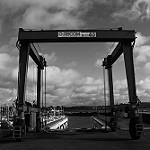

In [0]:
data.train_ds.x[1]

In [0]:
df_sorted = submission.sort_values(by=['confidence'])
df_sorted.head(10)

confidence image_name  label  pred
8953     0.328020  12729.jpg      0     0
9835     0.362289  14022.jpg      0     4
10639    0.364458  15188.jpg      4     4
5062     0.378107   7226.jpg      3     3
7862     0.382042  11233.jpg      4     2
10198    0.384537  14544.jpg      2     2
1217     0.386208   1733.jpg      1     2
16612    0.392396  23731.jpg      4     3
14093    0.396875  20133.jpg      3     1
13656    0.398016  19495.jpg      3     5

In [0]:
df_sorted.tail(10)

confidence image_name  label  pred
3300          1.0   4785.jpg      4     4
5859          1.0   8389.jpg      1     1
5546          1.0   7932.jpg      1     1
16869         1.0  24110.jpg      1     1
11162         1.0  15908.jpg      2     1
15396         1.0  22020.jpg      3     4
6492          1.0   9301.jpg      1     1
5851          1.0   8380.jpg      0     1
2283          1.0   3238.jpg      4     1
12530         1.0  17903.jpg      0     1

In [0]:
i = 1210
img = open_image(path/'train'/df_sorted['image_name'].values[i])
print(df_sorted['label'].values[i], df_sorted['pred'].values[i])

1 2


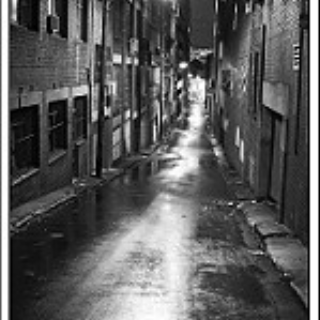

In [0]:
img.resize(320)

In [0]:
df_lowest_conf = df_sorted.loc[(df_sorted['confidence'] < 0.55) | (df_sorted['confidence']>0.999999)][df_sorted['label']!=df_sorted['pred']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [0]:
df_lowest_conf.shape

(257, 4)

In [0]:
df_lowest_conf.head(10)

confidence image_name  label  pred
9835     0.362289  14022.jpg      0     4
7862     0.382042  11233.jpg      4     2
1217     0.386208   1733.jpg      1     2
16612    0.392396  23731.jpg      4     3
14093    0.396875  20133.jpg      3     1
13656    0.398016  19495.jpg      3     5
14563    0.402263  20810.jpg      2     3
3400     0.402342   4922.jpg      5     2
3730     0.419084   5352.jpg      1     4
2946     0.425660   4173.jpg      3     2

In [0]:
df_lowest_conf.tail(10)

confidence image_name  label  pred
2224          1.0   3152.jpg      2     1
2875          1.0   4057.jpg      0     1
10583         1.0  15100.jpg      4     1
11192         1.0  15959.jpg      0     1
7887          1.0  11268.jpg      5     1
11162         1.0  15908.jpg      2     1
15396         1.0  22020.jpg      3     4
5851          1.0   8380.jpg      0     1
2283          1.0   3238.jpg      4     1
12530         1.0  17903.jpg      0     1

In [0]:
df_lowest_conf.to_csv('lowest_confidence.csv', index=False)

In [0]:
!cp data/train.csv data/train_old.csv
new_train_df = pd.read_csv(path/'train.csv')
new_train_df = new_train_df[~new_train_df['image_name'].isin(df_lowest_conf['image_name'])]
new_train_df.to_csv(path/'train.csv', index=False)

In [0]:
data = ImageDataBunch.from_csv(path=path, folder='train', csv_labels='train.csv', test='test', ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

In [0]:
learn_new = cnn_learner(get_data(224, 64), new_resnet, metrics=[error_rate, accuracy])

In [0]:
learn_new.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


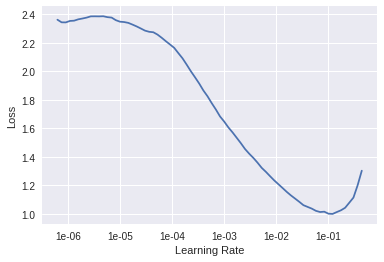

In [0]:
learn_new.recorder.plot()

In [0]:
learn_new.fit_one_cycle(5)

In [0]:
def make_submission(learn, filename):
  log_preds, test_labels = learn.get_preds(ds_type=DatasetType.Test)
  preds = np.argmax(log_preds, 1)
  a = np.array(preds)
  submission = pd.DataFrame({'image_name': os.listdir('data/test'), 'label': a})
  submission.to_csv(path/filename, index=False)

In [0]:
make_submission(learn_new, 'places_res50_224x224_conf.csv')

In [0]:
def make_submission_tta(learn, filename):
  log_preds, test_labels = learn.TTA(ds_type=DatasetType.Test)
  preds = np.argmax(log_preds, 1)
  a = np.array(preds)
  submission = pd.DataFrame({'image_name': os.listdir('data/test'), 'label': a})
  submission.to_csv(path/filename, index=False)

In [0]:
make_submission_tta(learn_new, 'places_res50_224x224_conf_tta.csv')

In [0]:
learn_new.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


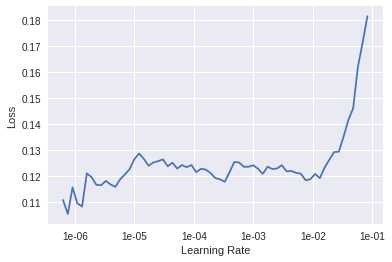

In [0]:
learn_new.recorder.plot()

In [0]:
learn_new.fit_one_cycle(6, max_lr=3e-06)

In [0]:
make_submission_tta(learn_new, 'places_res50_224x224_conf_lr_tta.csv')

In [0]:
learn_new.save('places_res50_224x224_conf_lr_tta_1')